In [201]:
#ALGORITHM = 'XG Boost'
ALGORITHM = 'Linear Regression (Ridge)'

ALGORITHM_DETAIL = 'random search'
DATA_DETAIL = []
#DATA_DETAIL = ['no scale','no dummies']
VERSION = '06'

RANDOM_STATE = 101
TRAINING_SIZE = 0.9

CROSS_VALIDATION_SCORING = 'r2'

print(f'ALGORITHM: {ALGORITHM}')
print(f'ALGORITHM_DETAIL: {ALGORITHM_DETAIL}')
print(f'DATA_DETAIL: {DATA_DETAIL}')
print(f'DATA VERSION: {VERSION}')


ALGORITHM: Linear Regression (ridge)
ALGORITHM_DETAIL: random search
DATA_DETAIL: []
DATA VERSION: 06


In [202]:
from sklearn.impute import SimpleImputer
import pandas as pd
from sklearn.model_selection import train_test_split, RandomizedSearchCV
import numpy as np
from pandas import DataFrame
import math
from termcolor import colored
from time import time
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.metrics import r2_score
import seaborn as sns
import pickle

import json
from datetime import datetime
import matplotlib.pyplot as plt

with open('../../z_envs/_envs.json') as f:
    env_vars = json.loads(f.read())
print(env_vars)

try:
    import google.colab

    run_env = 'colab'
except:
    try:
        run_env = env_vars['notebook_environment']
    except:
        run_env = 'unknown'

use_gpu = env_vars.get('use_gpu', False)
debug_mode = env_vars.get('debug_mode', False)
quick_mode = env_vars.get('quick_mode', False)
OVERRIDE_CV = env_vars.get('quick_override_cv_splits', None) if quick_mode else None
OVERRIDE_N_ITER = env_vars.get('quick_override_n_iter', None) if quick_mode else None
OVERRIDE_JOBS = env_vars.get('quick_override_n_jobs', None) if quick_mode else None
#if quick_mode:OVERRIDE_CV, OVERRIDE_N_ITER = 2, 10

if run_env not in ['colab', 'gradient', 'cloud']:
    cloud_run = False
    from functions_20221109 import set_csv_directory, get_columns
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters

    set_csv_directory('final_split')
else:
    cloud_run = True
    import sys
    import os

    module_path = os.path.abspath(os.path.join('..', '..', '..'))
    if module_path not in sys.path:
        #sys.path.append(module_path+"\\zfunctions")
        sys.path.append(module_path)

    from functions_20221109 import set_csv_directory, get_columns
    #from functions_20221109 import add_supplements, get_combined_dataset
    from functions_modelling_20221109 import make_modelling_pipeline, tidy_dataset, preprocess, feature_engineer, create_train_test_data
    from functions_modelling_20221109 import get_cv_params, fit_model_with_cross_validation, get_best_estimator_average_time
    from functions_modelling_20221109 import get_results, update_results, get_chosen_model
    from functions_modelling_20221109 import get_hyperparameters


{'notebook_environment': 'local', 'use_gpu': False, 'debug_mode': False, 'quick_mode': False, 'quick_override_cv_splits': 2, 'quick_override_n_iter': 10, 'quick_override_n_jobs': 3}


In [203]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, StandardScaler

starter_pipe = Pipeline([
    #('mms', MinMaxScaler()),
    ('std_scaler', StandardScaler()),
    ('model', get_chosen_model(ALGORITHM))
])
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', Ridge())])

In [204]:
#cutdown_rows = 1000
cutdown_rows = 0

LABEL = 'Price'

columns, booleans, floats, categories, custom, wildcard = get_columns(version=VERSION)

print(colored(f"features", "blue"), "-> ", columns)
columns.insert(0, LABEL)
print(colored(f"label", "green", None, ['bold']), "-> ", LABEL)

features ->  ['bedrooms', 'bathrooms', 'nearestStation', 'location.latitude', 'location.longitude', 'latitude_deviation', 'longitude_deviation', 'tenure.tenureType']
label ->  Price


In [205]:
def get_source_dataframe(rows=cutdown_rows, folder_prefix='../../../'):
    retrieval_type = None

    filename = f'df_listings_v{VERSION}.csv'
    remote_pathname = f'https://raw.githubusercontent.com/jayportfolio/capstone_streamlit/main/data/final/{filename}'
    df_pathname_raw = folder_prefix + f'data/source/{filename}'
    df_pathname_tidy = folder_prefix + f'data/final/{filename}'

    if cloud_run:
        inDF = pd.read_csv(remote_pathname, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', folder_prefix + remote_pathname)
    else:
        inDF = pd.read_csv(df_pathname_tidy, on_bad_lines='error', index_col=0)
        retrieval_type = 'tidy'
        print('loaded data from', df_pathname_tidy)

    if rows and rows > 0:
        inDF = inDF[:rows]
    return inDF, retrieval_type

In [206]:
df, retrieval_type = get_source_dataframe(folder_prefix='../../../')
df_orig = df.copy()

if retrieval_type != 'tidy':
    df = tidy_dataset(df, version=int(VERSION))
    df = feature_engineer(df, version=int(VERSION))

    df = df[columns]

print(df.shape)

loaded data from ../../../data/final/df_listings_v06.csv
(46871, 9)


In [207]:
df.head(30)

,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
14520525,550000.0,3.0,1.0,0.274316,51.529950,-0.207020,0.030230,0.102600,LEASEHOLD
27953107,400000.0,2.0,2.0,0.305845,51.549390,-0.482600,0.049670,0.378180,LEASEHOLD
33593487,579950.0,2.0,1.0,0.438045,51.447180,-0.338770,0.052540,0.234350,FREEHOLD
35271294,370000.0,2.0,1.0,0.399307,51.449568,-0.140154,0.050152,0.035734,LEASEHOLD
35429088,599950.0,2.0,1.0,0.238187,51.577030,-0.141230,0.077310,0.036810,NaN
44749111,475000.0,2.0,1.0,0.410550,51.370050,-0.212410,0.129670,0.107990,FREEHOLD
46204665,435000.0,3.0,2.0,0.314779,51.539070,-0.198935,0.039350,0.094515,LEASEHOLD
49020666,200000.0,1.0,1.0,0.875911,51.539959,-0.380863,0.040239,0.276443,LEASEHOLD
49036279,275000.0,2.0,1.0,0.474368,51.541780,0.037890,0.042060,0.142310,LEASEHOLD
49303873,450000.0,3.0,2.0,0.577040,51.524880,0.187200,0.025160,0.291620,FREEHOLD


In [208]:
df.isnull().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [209]:
df.info()
df.describe()
df.describe().T

<class 'pandas.core.frame.DataFrame'>
Int64Index: 46871 entries, 14520525 to 126181118
Data columns (total 9 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Price                46871 non-null  float64
 1   bedrooms             46871 non-null  float64
 2   bathrooms            46871 non-null  float64
 3   nearestStation       46871 non-null  float64
 4   location.latitude    46871 non-null  float64
 5   location.longitude   46871 non-null  float64
 6   latitude_deviation   46871 non-null  float64
 7   longitude_deviation  46871 non-null  float64
 8   tenure.tenureType    44127 non-null  object 
dtypes: float64(8), object(1)
memory usage: 3.6+ MB


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [210]:
old_length = len(df)

df = preprocess(df, version=VERSION)

print(f"dataframe contract due to cleaning: {old_length} ==> {len(df)}")
old_length = len(df)

df.describe().T

dataframe contract due to cleaning: 46871 ==> 46871


,count,mean,std,min,25%,50%,75%,max
Price,46871.0,425069.390775,107227.324906,100000.000000,349950.000000,425000.000000,515000.000000,600000.000000
bedrooms,46871.0,1.992469,0.828837,1.000000,1.000000,2.000000,3.000000,7.000000
bathrooms,46871.0,1.182074,0.409879,1.000000,1.000000,1.000000,1.000000,5.000000
nearestStation,46871.0,0.438847,0.325942,0.000000,0.227169,0.367971,0.559620,7.197700
location.latitude,46871.0,51.497049,0.077085,51.298317,51.438861,51.499977,51.556183,51.683185
location.longitude,46871.0,-0.113269,0.156489,-0.498315,-0.210796,-0.102230,-0.010343,0.279726
latitude_deviation,46871.0,0.064317,0.042573,0.000000,0.028876,0.058595,0.094362,0.201403
longitude_deviation,46871.0,0.124202,0.095607,0.000000,0.043560,0.098984,0.192684,0.393895


In [211]:
df.isna().sum()

Price                     0
bedrooms                  0
bathrooms                 0
nearestStation            0
location.latitude         0
location.longitude        0
latitude_deviation        0
longitude_deviation       0
tenure.tenureType      2744
dtype: int64

In [212]:
df = df.dropna()
print(f"{old_length} ==> {len(df)}")
old_length = len(df)
df.describe()

46871 ==> 44127


,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation
count,44127.000000,44127.000000,44127.00000,44127.000000,44127.000000,44127.000000,44127.000000,44127.000000
mean,425224.642373,1.990981,1.18134,0.438522,51.496711,-0.113106,0.064544,0.123699
std,107203.332660,0.827621,0.40893,0.324152,0.077267,0.155863,0.042583,0.095220
min,100000.000000,1.000000,1.00000,0.000000,51.298317,-0.498315,0.000000,0.000000
25%,349950.000000,1.000000,1.00000,0.227551,51.438303,-0.210633,0.029023,0.043551
50%,425000.000000,2.000000,1.00000,0.368351,51.498780,-0.101910,0.058904,0.098750
75%,515000.000000,3.000000,1.00000,0.559486,51.556343,-0.010854,0.094620,0.191727
max,600000.000000,7.000000,5.00000,7.197700,51.683185,0.279726,0.201403,0.393895


In [213]:
X_train, X_test, y_train, y_test, X_train_index, X_test_index, y_train_index, y_test_index, df_features, df_labels = create_train_test_data(
    df,
    categories=categories,
    RANDOM_STATE=RANDOM_STATE, return_index=True,
    drop_nulls=True)

print(X_train.shape, X_test.shape, y_train.shape, y_test.shape, X_train_index.shape, X_test_index.shape,
      y_train_index.shape, y_test_index.shape)


(39714, 11) (4413, 11) (39714, 1) (4413, 1) (39714, 1) (4413, 1) (39714, 1) (4413, 1)


In [214]:
#imputer = SimpleImputer(strategy='mean')
#imputer.fit(X_train[6])
#X_train[6] = imputer.transform(X_train[6])

In [215]:
fitted_graph_model = starter_pipe[-1]
default_model_params = fitted_graph_model.get_params()
default_model_params

{'alpha': 1.0,
 'copy_X': True,
 'fit_intercept': True,
 'max_iter': None,
 'normalize': 'deprecated',
 'positive': False,
 'random_state': None,
 'solver': 'auto',
 'tol': 0.001}

In [216]:
import sklearn

sklearn.metrics.get_scorer_names()

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'matthews_corrcoef',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_

In [217]:
%timeit starter_pipe.fit(X_train, y_train)

57.7 ms ± 10.7 ms per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [218]:
options_block = get_hyperparameters(ALGORITHM, use_gpu)

param_options, cv, n_jobs, refit, n_iter, verbose = get_cv_params(options_block, debug_mode=debug_mode,
                                                                  override_cv=OVERRIDE_CV,
                                                                  override_niter=OVERRIDE_N_ITER,
                                                                  override_njobs=OVERRIDE_JOBS)

print("cv:", cv, "n_jobs:", n_jobs, "refit:", refit, "n_iter:", n_iter, "verbose:", verbose)
param_options

cv: 3 n_jobs: 3 refit: True n_iter: 100 verbose: 1


{'model__alpha': [1e-05, 0.0001, 0.001, 0.01, 0.1, 1, 10, 100, 1000],
 'model__fit_intercept': [True, False],
 'model__max_iter': [100, 1000, 10000, 100000, 1000000],
 'model__positive': [True, False],
 'model__solver': ['auto',
  'svd',
  'cholesky',
  'lsqr',
  'sparse_cg',
  'sag',
  'saga',
  'lbfgs'],
 'model__tol': [1e-05, 0.0001, 0.001, 0.01],
 'model__random_state': [101]}

In [219]:
def fit_model_with_cross_validation(gs, X_train, y_train, fits):
    pipe_start = time()
    cv_result = gs.fit(X_train, y_train)
    gs.fit(X_train, y_train)
    pipe_end = time()
    average_time = round((pipe_end - pipe_start) / (fits), 2)

    print(f"Total fit/CV time      : {int(pipe_end - pipe_start)} seconds   ({pipe_start} ==> {pipe_end})")
    print()
    print(
        f'average fit/score time = {round(cv_result.cv_results_["mean_fit_time"].mean(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].mean(), 2)}s')
    print(
        f'max fit/score time     = {round(cv_result.cv_results_["mean_fit_time"].max(), 2)}s/{round(cv_result.cv_results_["mean_score_time"].max(), 2)}s')
    print(f'refit time             = {round(cv_result.refit_time_, 2)}s')

    #return cv_result, average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])
    return average_time, cv_result.refit_time_, len(cv_result.cv_results_["mean_fit_time"])


crossval_runner = RandomizedSearchCV(
    estimator=starter_pipe,
    param_distributions=param_options,
    cv=cv, n_jobs=n_jobs,  # get the AVX/AVX2 info if use n_jobs > 2
    verbose=verbose, scoring=CROSS_VALIDATION_SCORING,
    refit=refit,
    return_train_score=True,  #n_iter=n_iter,
    n_iter=n_iter,  # 1, #3
    #error_score='raise'
)

cv_average_fit_time, cv_best_model_fit_time, total_fits = fit_model_with_cross_validation(
    crossval_runner, X_train, y_train, fits=cv * n_iter)


Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
171 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
30 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_s

Fitting 3 folds for each of 100 candidates, totalling 300 fits


/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:378: FitFailedWarning: 
120 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
24 fits failed with the following error:
Traceback (most recent call last):
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/home/guava/PycharmProjects/capstone_streamlit/venv/lib/python3.8/site-packages/sklearn/pipeline.py", line 382, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/home/guava/PycharmProjects/capstone_s

Total fit/CV time      : 16 seconds   (1668290322.9079056 ==> 1668290339.4584754)

average fit/score time = 0.06s/0.0s
max fit/score time     = 0.47s/0.01s
refit time             = 0.33s


In [220]:
crossval_runner.best_params_
starter_pipe

Pipeline(steps=[('std_scaler', StandardScaler()), ('model', Ridge())])

In [221]:
best_estimator_pipe = crossval_runner.best_estimator_

if debug_mode:
    crossval_runner.cv_results_

In [222]:
cv_results_df = pd.DataFrame(crossval_runner.cv_results_).sort_values('rank_test_score')
cv_results_df

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_model__tol,param_model__solver,param_model__random_state,param_model__positive,param_model__max_iter,param_model__fit_intercept,...,split1_test_score,split2_test_score,mean_test_score,std_test_score,rank_test_score,split0_train_score,split1_train_score,split2_train_score,mean_train_score,std_train_score
69,0.261982,0.106838,0.003335,0.000640,0.001,sag,101,False,100,True,...,0.445849,0.446507,0.444667,0.002154,1,0.44679,0.444912,0.444609,0.445437,0.000965
55,0.021148,0.000472,0.002598,0.000111,0.0001,lsqr,101,False,1000,True,...,0.445852,0.446506,0.444666,0.002156,2,0.44679,0.444912,0.444614,0.445438,0.000963
37,0.021932,0.000150,0.002512,0.000298,0.0001,lsqr,101,False,100000,True,...,0.445852,0.446506,0.444666,0.002156,2,0.44679,0.444912,0.444614,0.445438,0.000963
81,0.020310,0.001172,0.002489,0.000175,0.0001,lsqr,101,False,10000,True,...,0.445852,0.446501,0.444666,0.002152,4,0.44679,0.444912,0.444614,0.445438,0.000963
16,0.137670,0.010409,0.002278,0.000061,0.0001,saga,101,False,100000,True,...,0.445847,0.446505,0.444664,0.002155,5,0.44679,0.444912,0.444614,0.445438,0.000963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
71,0.011437,0.000319,0.000000,0.000000,0.01,saga,101,True,10000,False,...,NaN,NaN,NaN,NaN,96,NaN,NaN,NaN,NaN,NaN
20,0.011558,0.000434,0.000000,0.000000,0.00001,sparse_cg,101,True,100,False,...,NaN,NaN,NaN,NaN,97,NaN,NaN,NaN,NaN,NaN
73,0.011379,0.000599,0.000000,0.000000,0.0001,sparse_cg,101,True,100000,False,...,NaN,NaN,NaN,NaN,98,NaN,NaN,NaN,NaN,NaN
75,0.015251,0.005536,0.000000,0.000000,0.01,sparse_cg,101,True,1000000,False,...,NaN,NaN,NaN,NaN,99,NaN,NaN,NaN,NaN,NaN


In [223]:
if debug_mode:
    xx = [c for c in cv_results_df.columns if 'param' in c]
    xx.insert(0, 'rank_test_score')
    xx.insert(0, 'mean_test_score')
    cv_results_df[xx].head(7)

In [224]:
if debug_mode:
    cv_results_df[xx].tail(7)

In [225]:
cv_results_df['params2'] = cv_results_df['params'].apply(lambda l: '/'.join([str(c) for c in l.values()]))

cv_columns = ['params2', 'rank_test_score', 'mean_test_score', 'mean_fit_time', 'mean_score_time', 'params']
# if 'Neural' not in ALGORITHM:
#     cv_columns.insert(2, 'mean_train_score')
cv_results_df_full_sorted = cv_results_df.sort_values('rank_test_score')[cv_columns].reset_index(drop=True)
cv_results_df_full_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.001/sag/101/False/100/True/0.001,1,0.444667,0.261982,0.003335,"{'model__tol': 0.001, 'model__solver': 'sag', ..."
1,0.0001/lsqr/101/False/1000/True/10,2,0.444666,0.021148,0.002598,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
2,0.0001/lsqr/101/False/100000/True/10,2,0.444666,0.021932,0.002512,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
3,0.0001/lsqr/101/False/10000/True/0.0001,4,0.444666,0.020310,0.002489,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
4,0.0001/saga/101/False/100000/True/10,5,0.444664,0.137670,0.002278,"{'model__tol': 0.0001, 'model__solver': 'saga'..."
...,...,...,...,...,...,...
95,0.01/saga/101/True/10000/False/0.1,96,NaN,0.011437,0.000000,"{'model__tol': 0.01, 'model__solver': 'saga', ..."
96,1e-05/sparse_cg/101/True/100/False/1,97,NaN,0.011558,0.000000,"{'model__tol': 1e-05, 'model__solver': 'sparse..."
97,0.0001/sparse_cg/101/True/100000/False/0.01,98,NaN,0.011379,0.000000,"{'model__tol': 0.0001, 'model__solver': 'spars..."
98,0.01/sparse_cg/101/True/1000000/False/0.0001,99,NaN,0.015251,0.000000,"{'model__tol': 0.01, 'model__solver': 'sparse_..."


In [226]:
cv_results_df_sorted = cv_results_df_full_sorted[cv_results_df_full_sorted['mean_test_score'] > -2]
if len(cv_results_df_sorted) != len(cv_results_df_full_sorted):
    print(-len(cv_results_df_sorted) + len(cv_results_df_full_sorted), "fits were total failures")
    total_fits = len(cv_results_df_sorted)
cv_results_df_sorted


74 fits were total failures


,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.001/sag/101/False/100/True/0.001,1,0.444667,0.261982,0.003335,"{'model__tol': 0.001, 'model__solver': 'sag', ..."
1,0.0001/lsqr/101/False/1000/True/10,2,0.444666,0.021148,0.002598,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
2,0.0001/lsqr/101/False/100000/True/10,2,0.444666,0.021932,0.002512,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
3,0.0001/lsqr/101/False/10000/True/0.0001,4,0.444666,0.020310,0.002489,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
4,0.0001/saga/101/False/100000/True/10,5,0.444664,0.137670,0.002278,"{'model__tol': 0.0001, 'model__solver': 'saga'..."
5,1e-05/sag/101/False/100000/True/0.001,6,0.444664,0.456265,0.002506,"{'model__tol': 1e-05, 'model__solver': 'sag', ..."
6,1e-05/sag/101/False/100000/True/1e-05,7,0.444664,0.417665,0.002457,"{'model__tol': 1e-05, 'model__solver': 'sag', ..."
7,0.0001/auto/101/False/10000/True/1,8,0.444663,0.015075,0.002167,"{'model__tol': 0.0001, 'model__solver': 'auto'..."
8,0.01/svd/101/False/100000/True/1,9,0.444663,0.028782,0.003235,"{'model__tol': 0.01, 'model__solver': 'svd', '..."
9,0.001/svd/101/False/100/True/1,9,0.444663,0.026999,0.002368,"{'model__tol': 0.001, 'model__solver': 'svd', ..."


In [227]:
def print_results(cross_validation_result):
    means = cross_validation_result.cv_results_['mean_test_score']
    stds = cross_validation_result.cv_results_['std_test_score']
    params = cross_validation_result.cv_results_['params']
    times = cross_validation_result.cv_results_['std_test_score']

    print("params:" + "/".join([c.replace("model__", "") for c in params[0].keys()]))
    print()
    for mean, std, param, time in zip(means, stds, params, times):
        #param2 = "/".join(list(param.values()))
        param2 = "/".join(list([str(c) for c in param.values()]))
        print(f'{round(mean, 3)} (+/-{round(std * 2, 3)}) in {round(time, 4)}s for {param2}')


if debug_mode:
    print_results(crossval_runner)

In [228]:
print('Best Index: ', crossval_runner.best_index_)
print('Best Score: ', crossval_runner.best_score_)
print('Best Params: ', crossval_runner.best_params_)

Best Index:  69
Best Score:  0.44466676507394154
Best Params:  {'model__tol': 0.001, 'model__solver': 'sag', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100, 'model__fit_intercept': True, 'model__alpha': 0.001}


In [229]:
y_pred = best_estimator_pipe.predict(X_test)

In [230]:
y_pred = y_pred.reshape((-1, 1))

R2 = r2_score(y_test, y_pred)
MAE = mean_absolute_error(y_test, y_pred)
MSE = mean_squared_error(y_test, y_pred)
RMSE = math.sqrt(MSE)
print('-' * 10 + ALGORITHM + '-' * 10)
print('R square Accuracy', R2)
print('Mean Absolute Error Accuracy', MAE)
print('Mean Squared Error Accuracy', MSE)
print('Root Mean Squared Error', RMSE)

----------Linear Regression (ridge)----------
R square Accuracy 0.456900104350899
Mean Absolute Error Accuracy 63601.874995444356
Mean Squared Error Accuracy 6135076718.216859
Root Mean Squared Error 78326.73054722033


In [231]:
if debug_mode:
    print(y_test_index.reshape((-1, 1)).shape);
    print(y_pred.reshape((-1, 1)).shape);
    print(y_test.shape);
    print(y_test_index.shape);
    print(y_pred.shape);
    print(y_test.shape)

In [232]:
compare = np.hstack((y_test_index, y_test, y_pred))
compare_df = DataFrame(compare, columns=['reference', 'actual', 'predicted'])
compare_df['difference'] = abs(compare_df['actual'] - compare_df['predicted'])
compare_df['diff 1 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['actual'] * 100)
compare_df['diff 2 %'] = abs((compare_df['actual'] - compare_df['predicted']) / compare_df['predicted']) * 100
compare_df['reference'] = compare_df['reference'].astype(int)
compare_df.set_index('reference', inplace=True)
compare_df

,actual,predicted,difference,diff 1 %,diff 2 %
reference,,,,,
85490754,400000.0,400220.431615,220.431615,0.055108,0.055078
119328242,369950.0,341261.042120,28688.957880,7.754820,8.406749
125716790,350000.0,453234.844677,103234.844677,29.495670,22.777341
122440040,549000.0,458341.726115,90658.273885,16.513347,19.779625
120508103,495000.0,484352.701490,10647.298510,2.150969,2.198253
...,...,...,...,...,...
68620869,475000.0,536258.313187,61258.313187,12.896487,11.423285
85735665,575000.0,658175.530569,83175.530569,14.465310,12.637287
125706338,400000.0,411440.657697,11440.657697,2.860164,2.780634


In [233]:
combined = compare_df.merge(df[columns], how='inner', left_index=True, right_index=True).sort_values(['diff 1 %'],
                                                                                                     ascending=False)
#pd.options.display.float_format = '{:.4f}'.format
combined[['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']] = combined[
    ['predicted', 'actual', 'Price', 'bedrooms', 'bathrooms']].astype(int)
combined['bedrooms'] = combined['bedrooms'].astype(int)
combined

,actual,predicted,difference,diff 1 %,diff 2 %,Price,bedrooms,bathrooms,nearestStation,location.latitude,location.longitude,latitude_deviation,longitude_deviation,tenure.tenureType
122265818,160000,584039,424039.485955,265.024679,72.604592,160000,3,1,0.166024,51.510420,-0.037730,0.010700,0.066690,FREEHOLD
85667184,122000,360056,238056.146063,195.127989,66.116396,122000,1,1,0.838896,51.540462,-0.280301,0.040742,0.175881,LEASEHOLD
109722224,108000,315104,207104.172006,191.763122,65.725620,108000,1,1,0.302667,51.406803,-0.261328,0.092917,0.156908,LEASEHOLD
83639617,190000,433684,243684.954146,128.255239,56.189396,190000,2,2,0.162816,51.491264,0.064660,0.008456,0.169080,LEASEHOLD
119684411,200000,431898,231898.789871,115.949395,53.692855,200000,2,1,0.511626,51.518081,-0.029340,0.018361,0.075080,LEASEHOLD
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
124085846,375000,374938,61.989046,0.016530,0.016533,375000,2,2,0.428537,51.357450,-0.199680,0.142270,0.095260,LEASEHOLD
110798696,400000,399939,60.675158,0.015169,0.015171,400000,2,2,0.339555,51.399354,-0.259059,0.100366,0.154639,LEASEHOLD
125723672,430000,429938,61.537086,0.014311,0.014313,430000,2,1,0.326995,51.536369,-0.248697,0.036649,0.144277,LEASEHOLD
119335547,575000,575074,74.841052,0.013016,0.013014,575000,4,2,0.298893,51.435710,0.050570,0.064010,0.154990,FREEHOLD


In [234]:
score = best_estimator_pipe.score(X_test, y_test)
score

0.456900104350899

In [235]:
r2_score(y_test, y_pred)

0.456900104350899

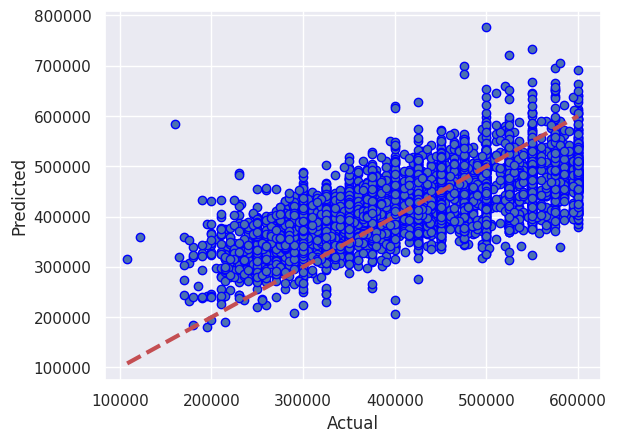

In [236]:
fig, ax = plt.subplots()
ax.scatter(y_test, best_estimator_pipe.predict(X_test), edgecolors=(0, 0, 1))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
ax.set_ylabel('Predicted')
ax.set_xlabel('Actual')
#ax.title.set_text(f'CV Chosen best option ({calculated_best_pipe[1]})')
plt.show()

In [237]:
def custom_model_and_predictions(model, graph_params, X_train, y_train, X_test):
    graph_model = model
    graph_model.set_params(**graph_params)
    graph_model.fit(X_train, y_train)
    y_pred_graph = model.predict(X_test)

    return model, y_pred_graph


best_model_count = 10 if not quick_mode else 2
best_model_count = 3 if not quick_mode else 1
best_models = {}
best_model_predictions = {}
best_model_scores = {}

showable_increment = total_fits // (4 if not quick_mode else 2)
for i in range(0, total_fits, showable_increment):
    if debug_mode or True: print(f'{i} ==> {i}')

    if i == 0:
        fitted_graph_model = crossval_runner.best_estimator_
        y_pred_graph = y_pred
    else:
        graph_pipe_params = cv_results_df_sorted['params'][i]
        print(graph_pipe_params)
        # would always return the best! graph_pipe_params = cv_results_df_sorted.loc[cv_results_df_sorted['rank_test_score'] == 1, 'params'].values[0]

        graph_params = {}
        for key, value in graph_pipe_params.items():
            graph_params[key.replace('model__', '')] = value

        fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                        y_train, X_test)

    best_models[i] = fitted_graph_model[-1].get_params()
    best_model_predictions[i] = y_pred_graph
    best_model_scores[i] = fitted_graph_model.score(X_test, y_test)

if debug_mode or True: print(f'{-1} ==> {-1}')
graph_pipe_params = cv_results_df_sorted['params'][total_fits - 1]
print(graph_pipe_params)
graph_params = {}
for key, value in graph_pipe_params.items():
    graph_params[key.replace('model__', '')] = value
fitted_graph_model, y_pred_graph = custom_model_and_predictions(starter_pipe, graph_pipe_params, X_train,
                                                                y_train, X_test)
best_models[-1] = fitted_graph_model[-1].get_params()
best_model_predictions[-1] = y_pred_graph
best_model_scores[-1] = fitted_graph_model.score(X_test, y_test)


0 ==> 0
6 ==> 6
{'model__tol': 1e-05, 'model__solver': 'sag', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100000, 'model__fit_intercept': True, 'model__alpha': 1e-05}
12 ==> 12
{'model__tol': 0.001, 'model__solver': 'sparse_cg', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100000, 'model__fit_intercept': True, 'model__alpha': 0.0001}
18 ==> 18
{'model__tol': 0.001, 'model__solver': 'svd', 'model__random_state': 101, 'model__positive': False, 'model__max_iter': 100000, 'model__fit_intercept': True, 'model__alpha': 1000}
24 ==> 24
{'model__tol': 0.0001, 'model__solver': 'lbfgs', 'model__random_state': 101, 'model__positive': True, 'model__max_iter': 100, 'model__fit_intercept': True, 'model__alpha': 0.01}
-1 ==> -1
{'model__tol': 0.0001, 'model__solver': 'lbfgs', 'model__random_state': 101, 'model__positive': True, 'model__max_iter': 100000, 'model__fit_intercept': True, 'model__alpha': 1e-05}


In [238]:
cv_results_df_sorted

,params2,rank_test_score,mean_test_score,mean_fit_time,mean_score_time,params
0,0.001/sag/101/False/100/True/0.001,1,0.444667,0.261982,0.003335,"{'model__tol': 0.001, 'model__solver': 'sag', ..."
1,0.0001/lsqr/101/False/1000/True/10,2,0.444666,0.021148,0.002598,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
2,0.0001/lsqr/101/False/100000/True/10,2,0.444666,0.021932,0.002512,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
3,0.0001/lsqr/101/False/10000/True/0.0001,4,0.444666,0.020310,0.002489,"{'model__tol': 0.0001, 'model__solver': 'lsqr'..."
4,0.0001/saga/101/False/100000/True/10,5,0.444664,0.137670,0.002278,"{'model__tol': 0.0001, 'model__solver': 'saga'..."
5,1e-05/sag/101/False/100000/True/0.001,6,0.444664,0.456265,0.002506,"{'model__tol': 1e-05, 'model__solver': 'sag', ..."
6,1e-05/sag/101/False/100000/True/1e-05,7,0.444664,0.417665,0.002457,"{'model__tol': 1e-05, 'model__solver': 'sag', ..."
7,0.0001/auto/101/False/10000/True/1,8,0.444663,0.015075,0.002167,"{'model__tol': 0.0001, 'model__solver': 'auto'..."
8,0.01/svd/101/False/100000/True/1,9,0.444663,0.028782,0.003235,"{'model__tol': 0.01, 'model__solver': 'svd', '..."
9,0.001/svd/101/False/100/True/1,9,0.444663,0.026999,0.002368,"{'model__tol': 0.001, 'model__solver': 'svd', ..."


In [239]:
if debug_mode:
    cv_results_df_sorted['params']

In [240]:
cv_results_df_sorted['params'][0]

{'model__tol': 0.001,
 'model__solver': 'sag',
 'model__random_state': 101,
 'model__positive': False,
 'model__max_iter': 100,
 'model__fit_intercept': True,
 'model__alpha': 0.001}

In [241]:
total_fits

26

In [242]:
best_models

{0: {'alpha': 0.001,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100,
  'normalize': 'deprecated',
  'positive': False,
  'random_state': 101,
  'solver': 'sag',
  'tol': 0.001},
 6: {'alpha': 1e-05,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100000,
  'normalize': 'deprecated',
  'positive': False,
  'random_state': 101,
  'solver': 'sag',
  'tol': 1e-05},
 12: {'alpha': 0.0001,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100000,
  'normalize': 'deprecated',
  'positive': False,
  'random_state': 101,
  'solver': 'sparse_cg',
  'tol': 0.001},
 18: {'alpha': 1000,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100000,
  'normalize': 'deprecated',
  'positive': False,
  'random_state': 101,
  'solver': 'svd',
  'tol': 0.001},
 24: {'alpha': 0.01,
  'copy_X': True,
  'fit_intercept': True,
  'max_iter': 100,
  'normalize': 'deprecated',
  'positive': True,
  'random_state': 101,
  'solver': 'lbfgs',
  'tol': 0.0001},
 -1: {'alpha': 1e-05,

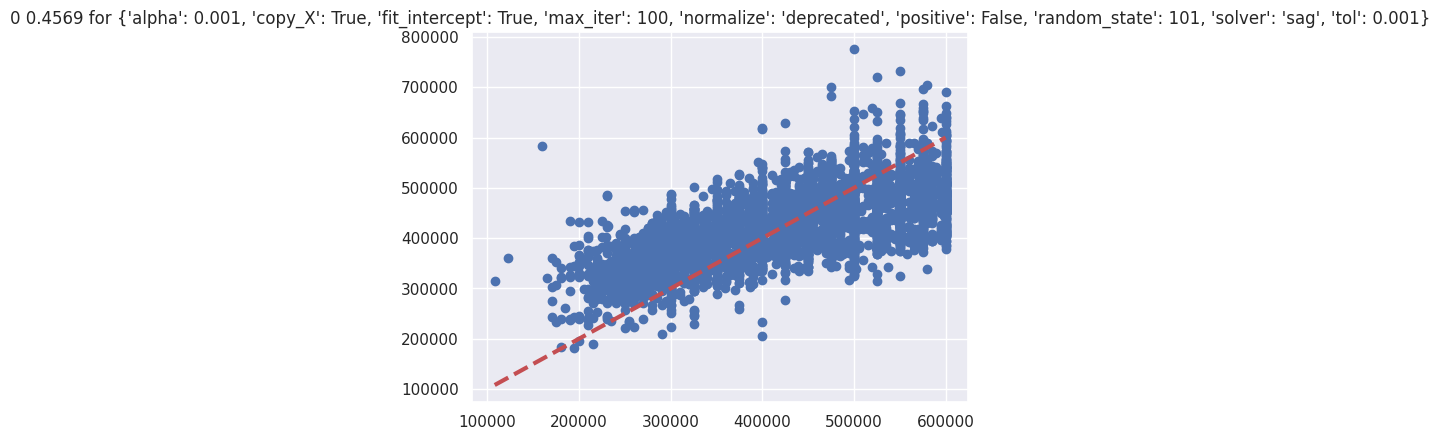

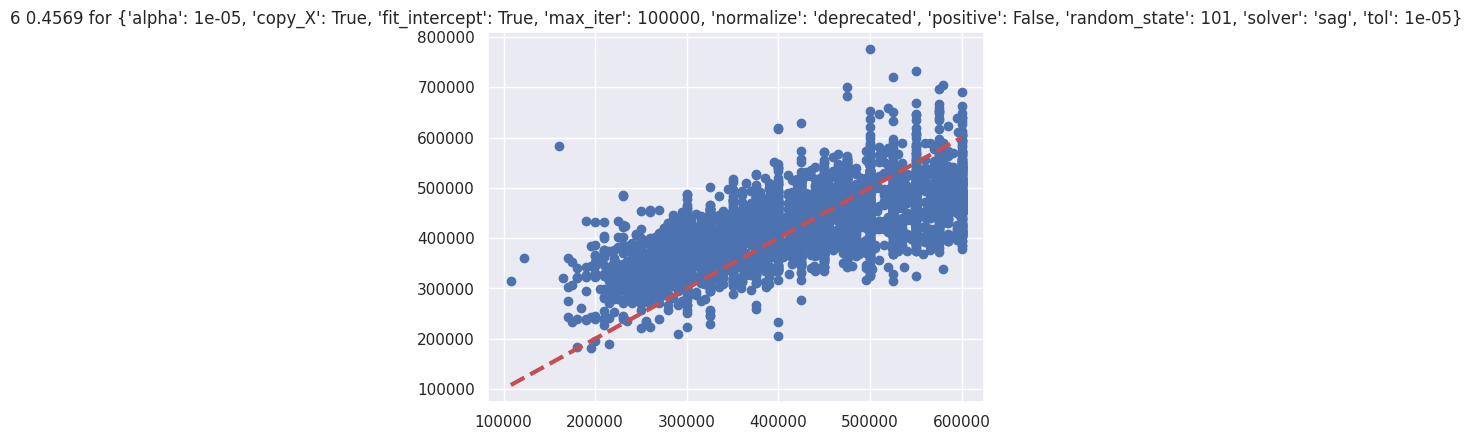

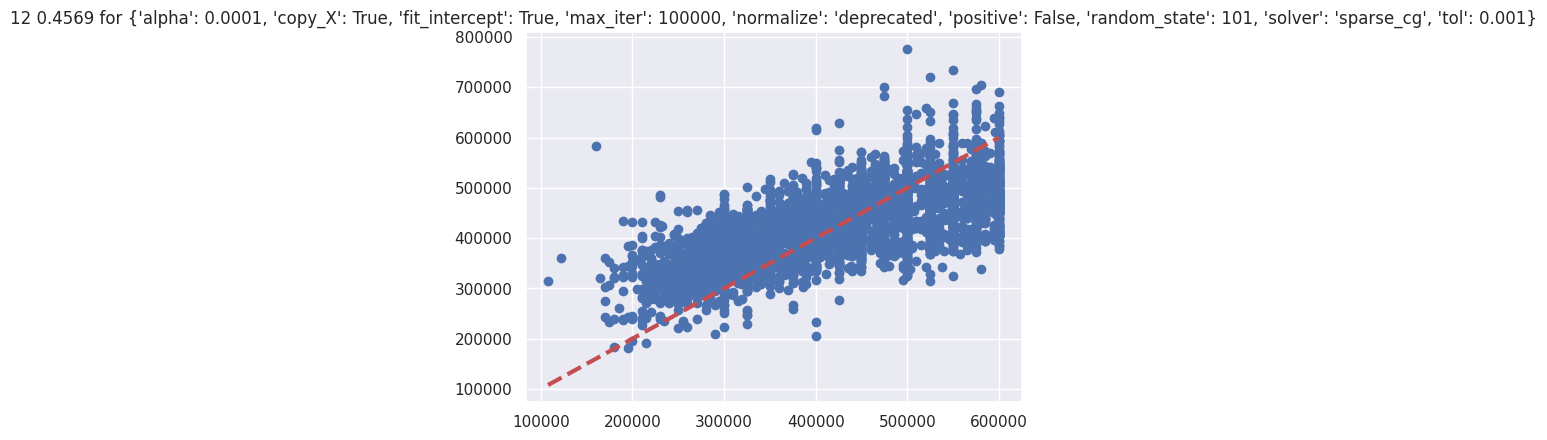

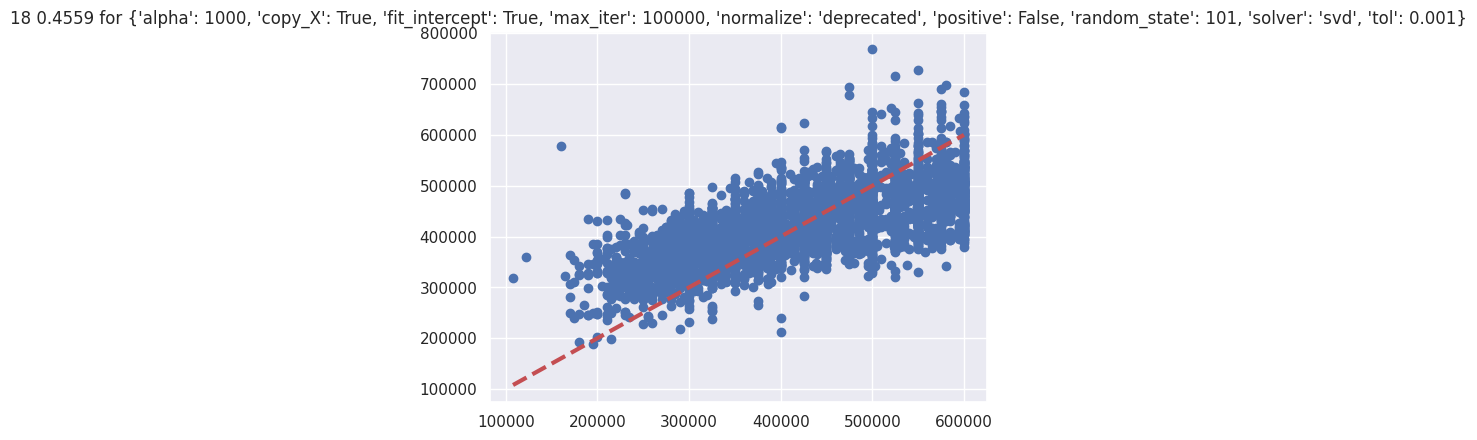

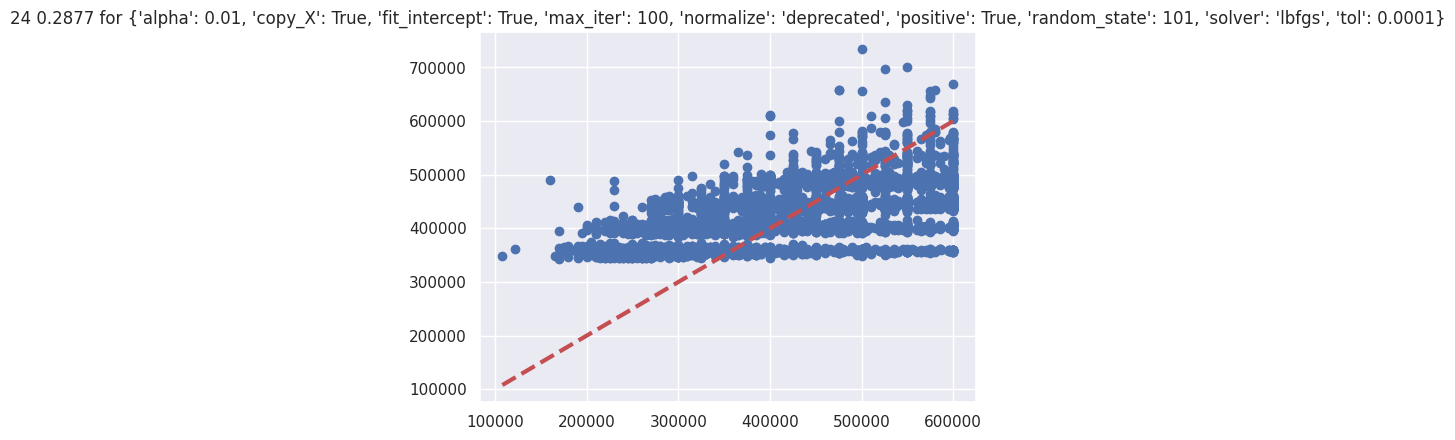

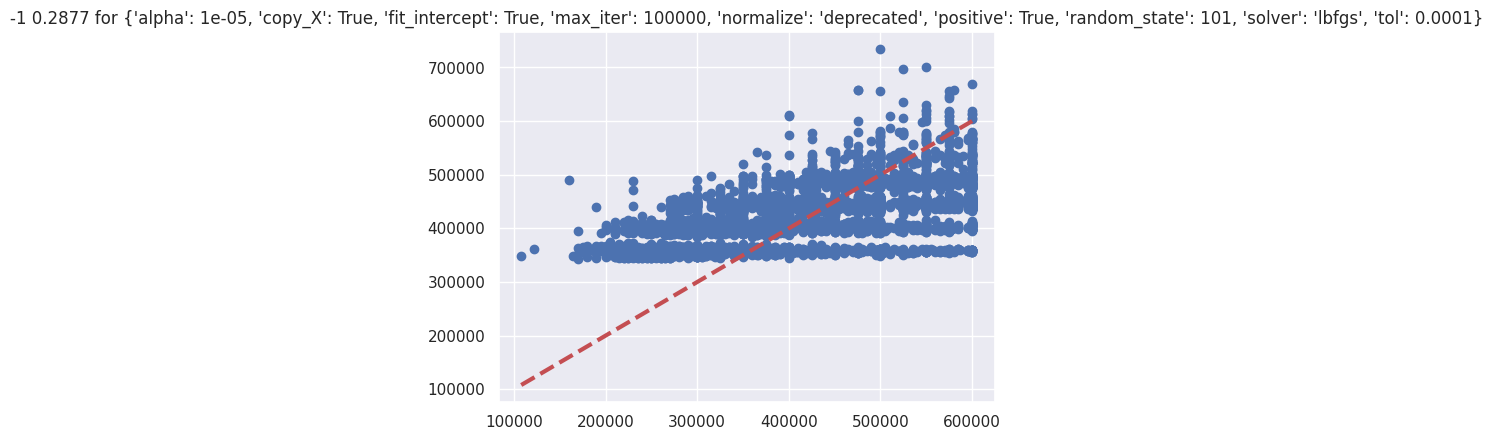

In [243]:
for i in best_model_scores.keys():
    if i >= 0:
        plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
        plt.scatter(y_test, best_model_predictions[i])
        # plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        if len(best_models[i].keys()) < 30:
            plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
        else:
            plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for entry " + str(i))
        plt.show()

plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=3)
plt.scatter(y_test, best_model_predictions[-1])
# plt.title(str(i) + " " + str(round(best_model_scores[i], 4)) + " for " + str(best_models[i]))
if len(best_models[i].keys()) < 30:
    plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for " + str(best_models[-1]))
else:
    plt.title(str(i) + " " + str(round(best_model_scores[-1], 4)) + " for (worst) entry " + str(i))

plt.show()

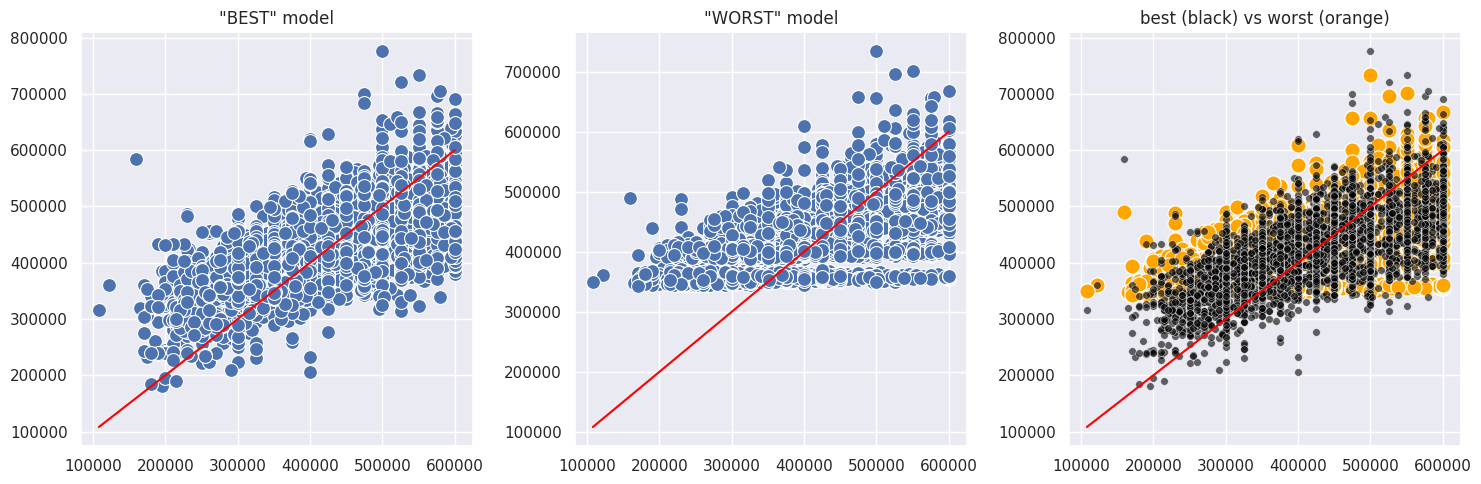

In [244]:
if True:
    sns.set_theme(font_scale=2, rc=None)
    sns.set_theme(font_scale=1, rc=None)

    fig, axes = plt.subplots(ncols=3, figsize=(15, 5))

    plt.subplots_adjust(hspace=0.2)
    plt.subplots_adjust(wspace=0.2)

    #.flatten()
    coordinates = axes[0]
    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[0], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[0],
                    s=100).set(title=f'"BEST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[1], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[1],
                    s=100).set(title=f'"WORST" model')

    sns.lineplot(x=[y_test.min(), y_test.max()], y=[y_test.min(), y_test.max()], ax=axes[2], color='red')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[-1].flatten(), ax=axes[2],
                    s=120, color='orange')
    sns.scatterplot(x=y_test.flatten(), y=best_model_predictions[0].flatten(), ax=axes[2],
                    s=30, alpha=0.6, color='black').set(
        title='best (black) vs worst (orange)')
    #title='best (orange) vs worst (black)')

    fig.tight_layout()
    plt.show()

In [245]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]
cv_best_model_fit_time

0.26198188463846844

In [246]:
cv_best_model_fit_time = cv_results_df_sorted.iloc[0]["mean_fit_time"]

DD2 = "(".join(DATA_DETAIL) + ")" if len(DATA_DETAIL) >= 1 else ""
key = f'{ALGORITHM} - {ALGORITHM_DETAIL}{DD2} (v{VERSION})'.lower()

results = {
    '_score': score,
    'R square Accuracy': R2,
    'Mean Absolute Error Accuracy': MAE,
    'Mean Squared Error Accuracy': MSE,
    'Root Mean Squared Error': RMSE,
    '_train time': cv_best_model_fit_time,
    'random_state': RANDOM_STATE,
    'date': str(datetime.now()),
    '_params': crossval_runner.best_params_,
    'run_env': run_env
}

if run_env not in ['colab']:
    results_json = get_results()
    this_model_is_best = update_results(results_json, results, key)

print(key)

linear regression (ridge) - random search (v06)


In [247]:
crossval_runner.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('model',
                 Ridge(alpha=0.001, max_iter=100, random_state=101,
                       solver='sag'))])

In [248]:
if this_model_is_best:
    with open(f'../../../models/optimised_model_{ALGORITHM}_v{VERSION}{DD2}.pkl', 'wb') as f:
        pickle.dump(crossval_runner.best_estimator_, f)
        print('pickled new version of model')
else:
    print("not updated saved model, the previous run was better")
    print(results_json[key]['best score'], 'better than', results_json[key]['_score'])

pickled new version of model


In [249]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or ALGORITHM.lower() == 'xg boost':
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
    #std = np.std([tree.feature_importances_ for tree in model.estimators_], axis = 0)

    indices = np.argsort(feature_importances)[::-1]

    print('Feature Ranking:')

    for f in range(X_train.shape[1]):
        print('%d. features %d (%f)' % (f + 1, indices[f], feature_importances[indices[f]]),
              df_features.columns[indices[f] + 1])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Linear Regression (ridge) does not have feature_importances, skipping


In [250]:
if 'tree' in ALGORITHM.lower() or 'forest' in ALGORITHM.lower() or ALGORITHM.lower() == 'xg boost':
    feature_importances = crossval_runner.best_estimator_[-1].feature_importances_
    indices = np.argsort(feature_importances)

    fig, ax = plt.subplots()
    ax.barh(range(len(feature_importances)), feature_importances[indices])
    ax.set_yticks(range(len(feature_importances)))
    _ = ax.set_yticklabels(df_features.columns[[c + 1 for c in indices]])
else:
    print(f'{ALGORITHM} does not have feature_importances, skipping')

Linear Regression (ridge) does not have feature_importances, skipping
